In [1]:
%matplotlib inline 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

mpl.rc('font', size=15)

Using TensorFlow backend.


## Import data
Import time series, metadata, and labels. Separate into training and validation data

In [2]:
import pickle

with open('data/training_data.pkl', 'rb') as f:
    data_dict = pickle.load(f)
    
X_conv = data_dict['X'] 
X_meta = data_dict['metaX']
y = data_dict['y']

tfrac = int(0.8*y.shape[0])
X_conv_train = X_conv[:tfrac]
X_conv_val = X_conv[tfrac:]
X_meta_train = X_meta[:tfrac]
X_meta_val = X_meta[tfrac:]
y_train = y[:tfrac]
y_val = y[tfrac:]

print('')
print('X_conv_train shape: {}'.format(X_conv_train.shape))
print('X_conv_val shape  : {}'.format(X_conv_val.shape))
print('X_meta_train shape: {}'.format(X_meta_train.shape))
print('X_meta_val shape  : {}'.format(X_meta_val.shape))
print('y_train shape     : {}'.format(y_train.shape))
print('y_val shape       : {}'.format(y_val.shape))


X_conv_train shape: (6278, 72, 12)
X_conv_val shape  : (1570, 72, 12)
X_meta_train shape: (6278, 8)
X_meta_val shape  : (1570, 8)
y_train shape     : (6278, 14)
y_val shape       : (1570, 14)


## Create network

In [3]:
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.models import Model
from keras import regularizers
from keras.initializers import glorot_normal
from keras.optimizers import Adam

In [4]:
def PhNet(num_classes, conv_shape, dense_shape=None, lr=1e-3, reg=1e-2, dropout=0.1):

    # convolution layer
    conv_input = Input(shape=conv_shape, name='light_curve_input')
    conv = Conv1D(filters=8, 
                  kernel_size=5, 
                  strides=1, 
                  padding='same',
                  kernel_regularizer=regularizers.l2(reg),
                  kernel_initializer=glorot_normal())(conv_input)
    conv = BatchNormalization(axis=2)(conv)
    conv = Activation('relu')(conv)
    conv = MaxPooling1D(2)(conv)
    conv = Flatten()(conv)
    conv = Dense(32, activation='relu')(conv)

    # dense layer
    if dense_shape is not None:
        dense_input = Input(shape=dense_shape, name='meta_data')
        dense = Dense(16, activation='relu')(dense_input)
        dense = BatchNormalization(axis=1)(dense)
        dense = Dense(32, activation='relu')(dense)

        # merge layer
        x = concatenate([conv, dense])
    else: 
        x = conv

    x = Dense(64, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(num_classes, 
              kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',
              name='output')(x)

    # optimizer
    adam = Adam(lr=lr)
    
    if dense_shape is not None:
        model = Model(inputs=[conv_input, dense_input], outputs=x, name='PhNet')
    else:
        model = Model(inputs=conv_input, outputs=x, name='PhNet')
    model.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
two_model = PhNet(conv_shape=X_conv_train.shape[1:], 
                  dense_shape=X_meta_train.shape[1:], 
                  num_classes=y.shape[1])

plot_model(two_model, to_file='two_model.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [7]:
two_stats = two_model.fit(x=[X_conv_train, X_meta_train], 
                          y=y_train, 
                          epochs=50, 
                          batch_size=32, 
                          validation_data=([X_conv_val, X_meta_val], y_val),
                          verbose=2)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 2s - loss: 2.3884 - acc: 0.2996 - val_loss: 2.3475 - val_acc: 0.2592
Epoch 2/50
 - 1s - loss: 2.0899 - acc: 0.3371 - val_loss: 2.2689 - val_acc: 0.2841
Epoch 3/50
 - 1s - loss: 1.9372 - acc: 0.3777 - val_loss: 2.2063 - val_acc: 0.3032
Epoch 4/50
 - 1s - loss: 1.8255 - acc: 0.4041 - val_loss: 2.1315 - val_acc: 0.3439
Epoch 5/50
 - 1s - loss: 1.7460 - acc: 0.4145 - val_loss: 2.0349 - val_acc: 0.3350
Epoch 6/50
 - 1s - loss: 1.6809 - acc: 0.4458 - val_loss: 2.0063 - val_acc: 0.3611
Epoch 7/50
 - 1s - loss: 1.6637 - acc: 0.4564 - val_loss: 2.0843 - val_acc: 0.3389
Epoch 8/50
 - 1s - loss: 1.6323 - acc: 0.4681 - val_loss: 1.9557 - val_acc: 0.3567
Epoch 9/50
 - 1s - loss: 1.5896 - acc: 0.4744 - val_loss: 1.9468 - val_acc: 0.3688
Epoch 10/50
 - 1s - loss: 1.5531 - acc: 0.4817 - val_loss: 1.9364 - val_acc: 0.3860
Epoch 11/50
 - 1s - loss: 1.5257 - acc: 0.4845 - val_loss: 1.8934 - val_acc: 0.3777
Epoch 12/50
 - 1s - loss: 1.4973 - ac

## Plot accuracy curve and confusion matrix

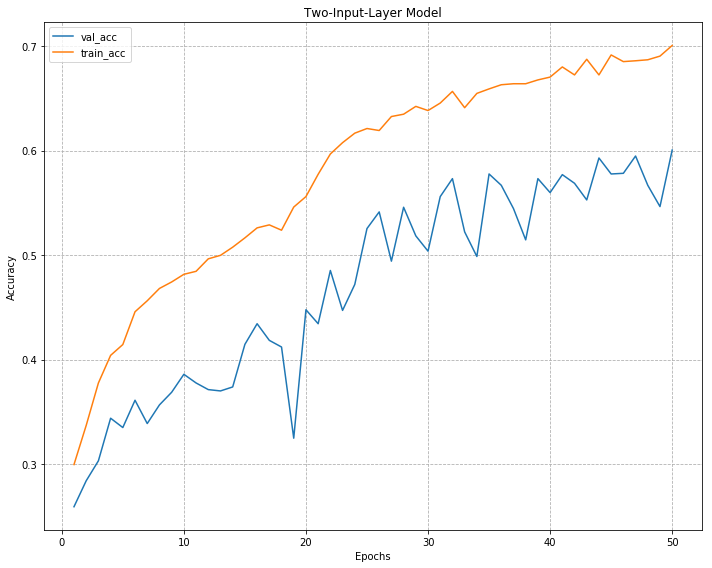

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 8))

val_acc = two_stats.history['val_acc']
train_acc = two_stats.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title='Two-Input-Layer Model')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

plt.savefig('two_acc.png', dpi=100)

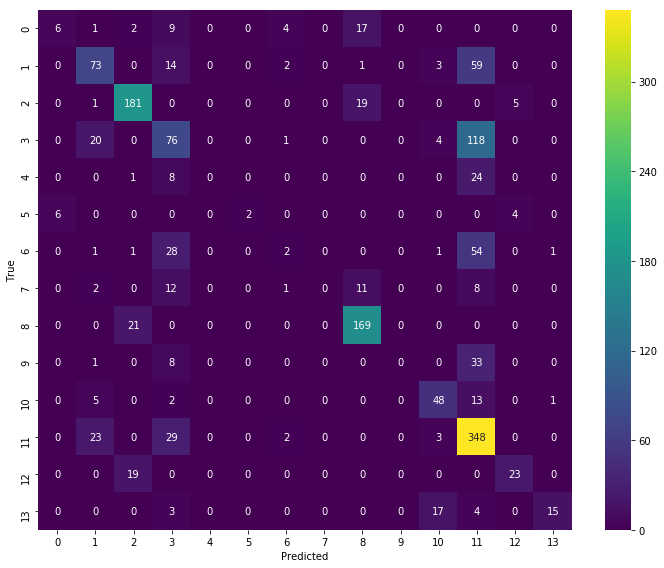

In [14]:
ypred = np.argmax(two_model.predict([X_conv_val, X_meta_val]), axis=1)
ytrue = np.array([np.where(r==1)[0][0] for r in y_val])
cm = metrics.confusion_matrix(ytrue, ypred)

fig, ax = plt.subplots(1, figsize=(10, 8))
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='viridis',
           xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted')

fig.tight_layout()

plt.savefig('two_confusion.png', dpi=100)

## Compare performance without metadata

In [11]:
one_model = PhNet(conv_shape=X_conv_train.shape[1:], 
                  num_classes=y.shape[1])

plot_model(one_model, to_file='one_model.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [12]:
one_stats = one_model.fit(x=X_conv_train, 
                          y=y_train,  
                          epochs=50, 
                          batch_size=32, 
                          validation_data=(X_conv_val, y_val),
                          verbose=2)

Train on 6278 samples, validate on 1570 samples
Epoch 1/50
 - 1s - loss: 2.5021 - acc: 0.2985 - val_loss: 2.3713 - val_acc: 0.2618
Epoch 2/50
 - 1s - loss: 2.0904 - acc: 0.3523 - val_loss: 2.2803 - val_acc: 0.2879
Epoch 3/50
 - 1s - loss: 1.9300 - acc: 0.3756 - val_loss: 2.1462 - val_acc: 0.3108
Epoch 4/50
 - 1s - loss: 1.8139 - acc: 0.3901 - val_loss: 2.1283 - val_acc: 0.3274
Epoch 5/50
 - 1s - loss: 1.7494 - acc: 0.4098 - val_loss: 2.0715 - val_acc: 0.3159
Epoch 6/50
 - 1s - loss: 1.7049 - acc: 0.4176 - val_loss: 2.0312 - val_acc: 0.3242
Epoch 7/50
 - 1s - loss: 1.6772 - acc: 0.4387 - val_loss: 1.9991 - val_acc: 0.3318
Epoch 8/50
 - 1s - loss: 1.6687 - acc: 0.4409 - val_loss: 1.9124 - val_acc: 0.3529
Epoch 9/50
 - 1s - loss: 1.6042 - acc: 0.4651 - val_loss: 1.9738 - val_acc: 0.3414
Epoch 10/50
 - 1s - loss: 1.5990 - acc: 0.4642 - val_loss: 1.8565 - val_acc: 0.3707
Epoch 11/50
 - 1s - loss: 1.5693 - acc: 0.4845 - val_loss: 1.8930 - val_acc: 0.3796
Epoch 12/50
 - 1s - loss: 1.5314 - ac

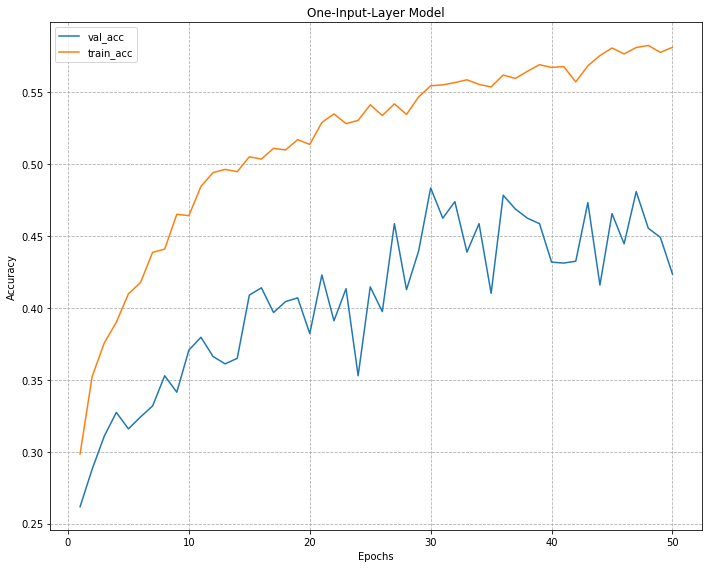

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 8))

val_acc = one_stats.history['val_acc']
train_acc = one_stats.history['acc']
epochs = np.arange(1, len(val_acc)+1)

ax.plot(epochs, val_acc, label='val_acc')
ax.plot(epochs, train_acc, label='train_acc')
ax.set(xlabel='Epochs', ylabel='Accuracy', title='One-Input-Layer Model')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

plt.savefig('one_acc.png', dpi=100)

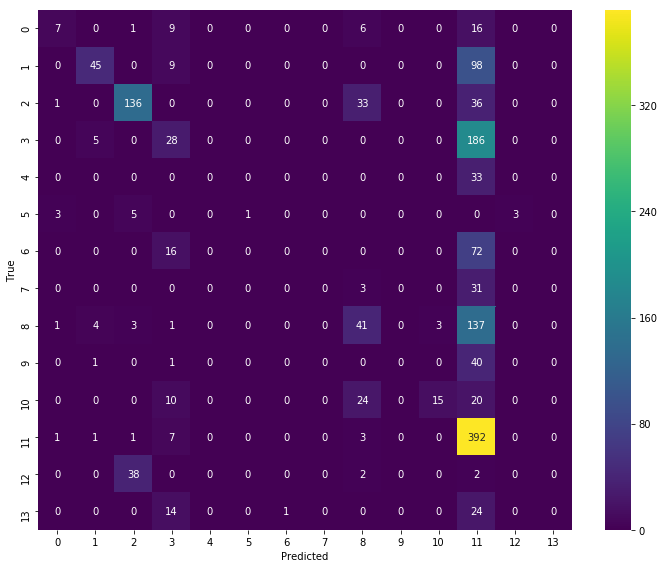

In [15]:
ypred = np.argmax(one_model.predict(X_conv_val), axis=1)
ytrue = np.array([np.where(r==1)[0][0] for r in y_val])
cm = metrics.confusion_matrix(ytrue, ypred)

fig, ax = plt.subplots(1, figsize=(10, 8))
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='viridis',
           xticklabels=np.arange(14), yticklabels=np.arange(14))
ax.set(ylabel='True', xlabel='Predicted')

fig.tight_layout()

plt.savefig('one_confusion.png', dpi=100)